In [45]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from PIL import Image
import time

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

In [4]:
# Load the data
df = pd.read_csv('../frameRecorder/data.csv')

df.head()

,image_id,q,z,s,d,zq,zd,sq,sd
0,1682028946060,0,0,0,0,0,0,0,0
1,1682028946095,0,0,0,0,0,0,0,0
2,1682028946131,0,0,0,0,0,0,0,0
3,1682028946166,0,1,0,0,0,0,0,0
4,1682028946196,0,1,0,0,0,0,0,0


In [5]:
counts = df.sum()
print(counts)
min_count = counts.min()
print(min_count)

image_id    24599687019114602
q                         308
z                        6471
s                         939
d                         296
zq                        365
zd                        419
sq                         40
sd                         53
dtype: int64
40


In [15]:
X, y = df.iloc[:, 0], df.iloc[:, 1:]
print(X[0:10])
print(X.shape)
print(y.shape)

0    1682028946060
1    1682028946095
2    1682028946131
3    1682028946166
4    1682028946196
5    1682028946227
6    1682028946264
7    1682028946301
8    1682028946337
9    1682028946374
Name: image_id, dtype: int64
(14625,)
(14625, 8)


In [67]:
XX_road = []
XX_map = []
for i in X:
    img = cv.imread('../frameRecorder/screenshots/' + str(i) + '.png')
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (200, 150))
    img = img / 255
    XX_road.append(img)
    img = cv.imread('../frameRecorder/screenshots/' + str(i) + '_map.png')
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (145, 100))
    img = img / 255
    XX_map.append(img)

In [17]:
# split the data into training , validation and testing sets
X_train_road, X_test_road, X_train_map, X_test_map, y_train, y_test = train_test_split(XX_road, XX_map, y, test_size=0.2, random_state=42)
X_test_road, X_val_road, X_test_map, X_val_map, y_test, y_val = train_test_split(X_test_road, X_test_map, y_test, test_size=0.5, random_state=42)

In [18]:
X_train_road = np.array(X_train_road)
X_test_road = np.array(X_test_road)
X_val_road = np.array(X_val_road)
X_train_map = np.array(X_train_map)
X_test_map = np.array(X_test_map)
X_val_map = np.array(X_val_map)

In [19]:
print(X_train_road.shape)
print(X_test_road.shape)
print(X_val_road.shape)
print(X_train_map.shape)
print(X_test_map.shape)
print(X_val_map.shape)

(11700, 150, 200, 3)
(1462, 150, 200, 3)
(1463, 150, 200, 3)
(11700, 100, 145, 3)
(1462, 100, 145, 3)
(1463, 100, 145, 3)


In [37]:
with tf.compat.v1.Session(config=config) as sess:
    model_1 = Sequential([
        Conv2D(24, (5, 5), (2, 2), activation='relu', input_shape=(150, 200, 3)),
        Conv2D(36, (5, 5), (2, 2), activation='relu'),
        Conv2D(48, (5, 5), (2, 2), activation='relu'),
        Conv2D(64, (3, 3), (2, 2), activation='relu'),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dense(10, activation='relu'),
    ])
    # another model 
    model_2 = Sequential([
        Conv2D(22, kernel_size=(3, 3), activation='relu', input_shape=(100, 145, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(28, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(34, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(40, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(100, activation='relu'),
        Dense(50, activation='relu'),
        Dense(15, activation='relu'),
    ])

    # concatenate two models
    combinedInput = layers.concatenate([model_1.output, model_2.output])
    x = Dense(10, activation="relu")(combinedInput)
    x = Dense(8, activation="softmax")(x)
    model = keras.Model(inputs=[model_1.input, model_2.input], outputs=x)
    

In [38]:
# compile the model
with tf.compat.v1.Session(config=config) as sess:
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize the model
    model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_23_input (InputLayer)   [(None, 100, 145, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 98, 143, 22)  616         ['conv2d_23_input[0][0]']        
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 49, 71, 22)  0           ['conv2d_23[0][0]']              
                                                                                                  
 conv2d_24 (Conv2D)             (None, 47, 69, 28)   5572        ['max_pooling2d_8[0][0]']  

In [39]:
# print a graph of the model
with tf.compat.v1.Session(config=config) as sess:
    tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

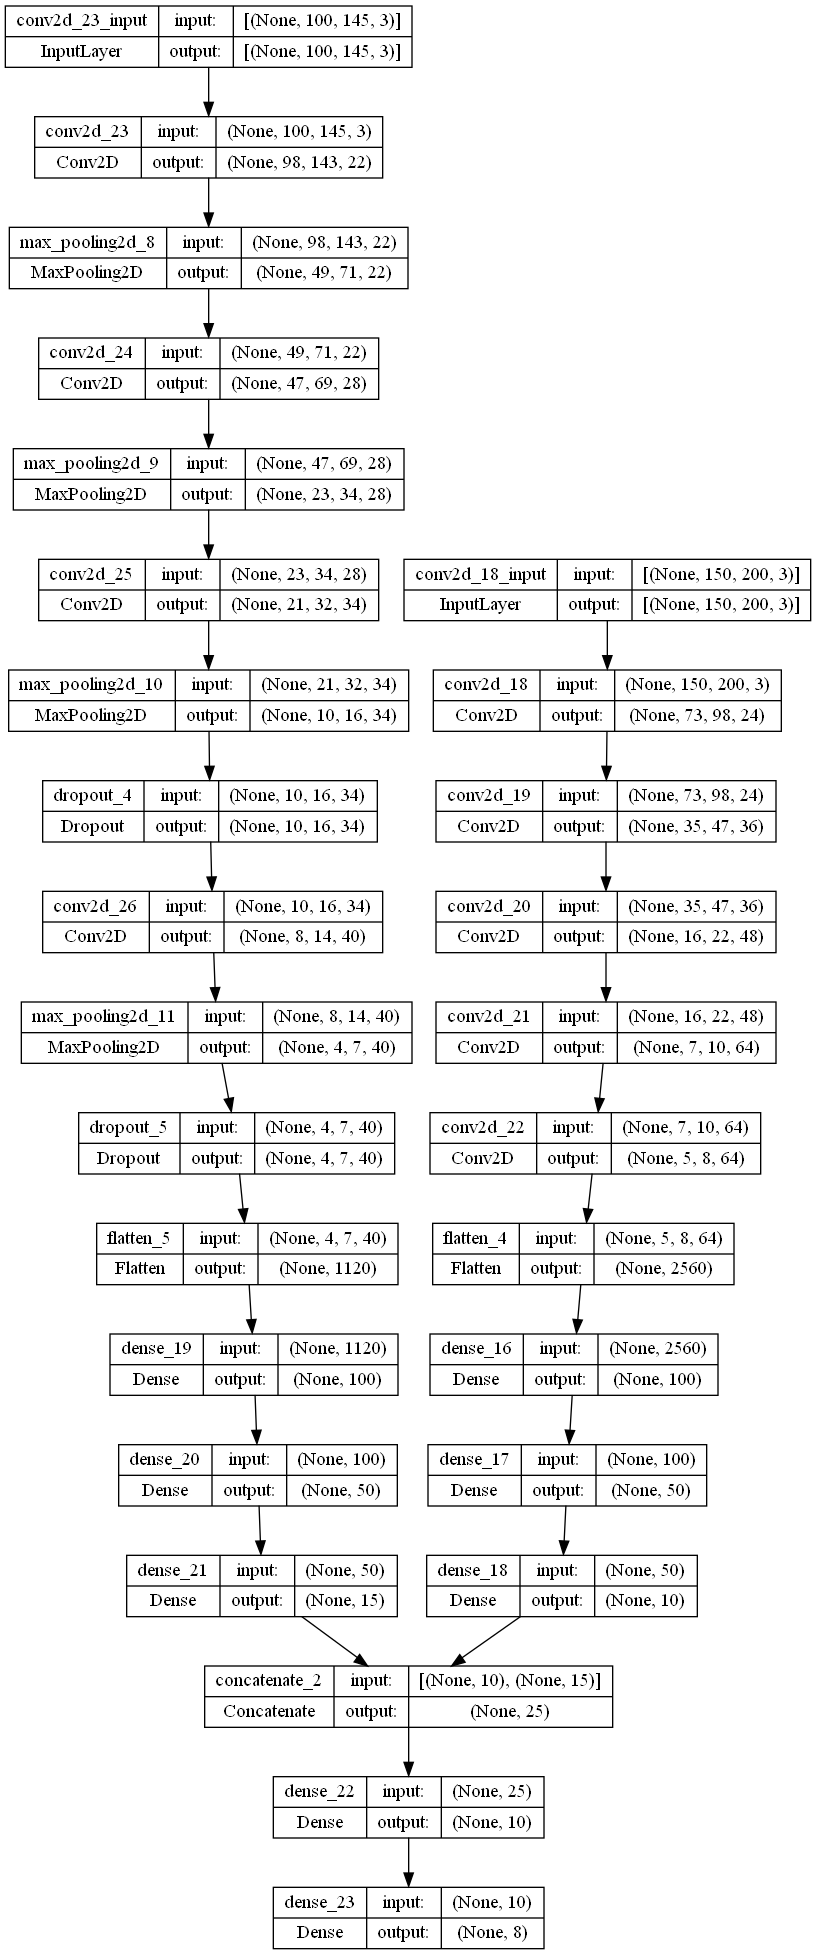

In [40]:
# show the image model.png 
plot_model(model, show_shapes=True, show_layer_names=True)

In [41]:
# train the model
with tf.compat.v1.Session(config=config) as sess:
    history = model.fit([X_train_road, X_train_map], y_train, epochs=5, batch_size=64, validation_data=([X_val_road, X_val_map], y_val))
    # save the model
    model.save('final_model_v1_0_0.h5')

Train on 11700 samples, validate on 1463 samples
Epoch 1/5
11700/11700 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.9166

c:\Users\Mouad\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


11700/11700 [==============================] - 62s 5ms/sample - loss: 0.2617 - accuracy: 0.9166 - val_loss: 0.1823 - val_accuracy: 0.9032
Epoch 2/5
11700/11700 [==============================] - 51s 4ms/sample - loss: 0.1703 - accuracy: 0.9111 - val_loss: 0.1670 - val_accuracy: 0.9118
Epoch 3/5
11700/11700 [==============================] - 52s 4ms/sample - loss: 0.1541 - accuracy: 0.9164 - val_loss: 0.1522 - val_accuracy: 0.9140
Epoch 4/5
11700/11700 [==============================] - 48s 4ms/sample - loss: 0.1380 - accuracy: 0.9233 - val_loss: 0.1298 - val_accuracy: 0.9222
Epoch 5/5
11700/11700 [==============================] - 46s 4ms/sample - loss: 0.1187 - accuracy: 0.9283 - val_loss: 0.1169 - val_accuracy: 0.9259


c:\Users\Mouad\anaconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test Accuracy: 0.9339945316314697
Test Loss: 0.10782591329961404


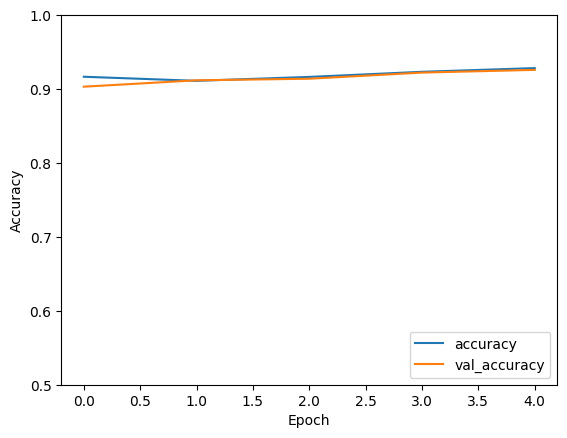

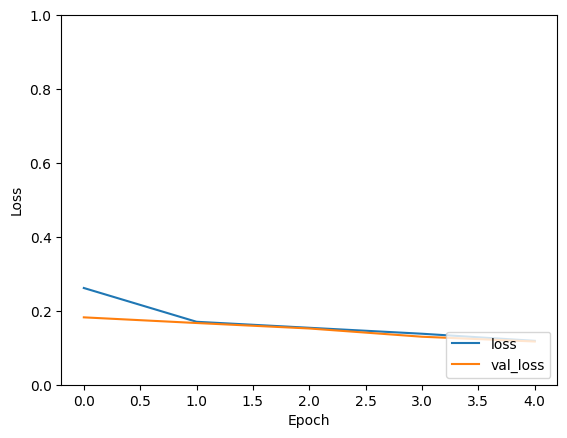

In [46]:
# evaluate the model
with tf.compat.v1.Session(config=config) as sess:
    # load the model
    model = load_model('final_model_v1_0_0.h5') 

    loss, acc = model.evaluate([X_test_road, X_test_map], y_test, verbose=2)
    print('Test Accuracy: {}'.format(acc))
    print('Test Loss: {}'.format(loss))

    # plot the accuracy
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

    # plot the loss
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

In [68]:
# make predictions
with tf.compat.v1.Session(config=config) as sess:
    # load the model
    model = load_model('final_model_v1_0_0.h5')

    temp_XX_road = np.array(XX_road[110])
    temp_XX_map = np.array(XX_map[110])

    start = time.time()
    prediction = model.predict([temp_XX_road, temp_XX_map])
    end = time.time()
    print('Time taken to predict: {}'.format(end - start))
    print('[', end='')
    for(i, j) in enumerate(prediction[0]):
        print(f'{round(j, 2)}', end=' ')
    print(']')

    plt.imshow(XX_road[110])
    plt.show()

ValueError: Error when checking input: expected conv2d_18_input to have 4 dimensions, but got array with shape (150, 200, 3)